# The HFM library - A fast marching solver with adaptive stencils

## Part : Isotropic and anisotropic metrics
## Chapter : Riemannian metrics

In this notebook, we demonstrate anisotropic Riemannian fast marching, in two and three dimensions. The implementation and the numerical examples are based on the paper:
* <a name="cite_Mirebeau_2017_Voronoi">[Mir17]</a> J.-M. Mirebeau, “Anisotropic fast-marching on cartesian grids using Voronoi's first reduction of quadratic forms,” SINUM, 2019. [link](https://hal.archives-ouvertes.fr/hal-01507334)

More formally, we numerically solve Riemannian eikonal equations, and backtrack the corresponding minimal geodesics. In order to describe this mathematical problem we need to introduce some notation. Let $\Omega \subset \mathbb R^d$ be a domain, let $D : \Omega \to S^{++}(\mathbb R^d)$ be a field of positive definite tensors, and let $\sigma : \partial \Omega \to ]-\infty,\infty]$ denote some boundary data. 
We seek the viscosity solution $u : \overline \Omega \to ]-\infty,\infty]$ to the partial differential equation
\begin{align*}
    \forall x \in \Omega, \|\nabla u(x)\|_{D(x)} &= 1 &
    \forall x \in \partial \Omega, u(x) &= \sigma(x).
\end{align*}
We denoted by $\|v\|_D := \sqrt{v^T\cdot D \cdot v}$ the anisotropic norm of a vectors $v \in \mathbb R^d$ defined by a positive definite tensor $D\in S^{++}(\mathbb R^d)$.


The solution value $u(x)$, for $x\in \Omega$, is known to be the minimal Riemannian length (plus the initial penalization $\sigma$) of a path $\gamma : [0,1] \to \overline \Omega$ from $\partial \Omega$ to $x$. 
\begin{equation*}
    u(x) = \inf_{\substack{\gamma(0) \in \partial \Omega\\ \gamma(1)=x}} \sigma(\gamma(0)) + \int_0^1 \| \gamma'(t) \|_{M(\gamma(t))} \, \mathrm d t.
\end{equation*}
In the last equation, path length is measured using the Riemannian metric $M : \Omega \to S^{++}(\mathbb R^d)$ defined as the inverse $M = D^{-1}$ of the tensor fields appearing in the eikonal PDE.


**Anisotropy of a Riemannian metric.**
Denote by $\mu(M)$ the anisotropy of a positive definite tensor, which is also the square root of its condition number:
$$
    \mu(M) := \max_{|v|=|w|=1} \frac {\|v\|_M}{\|w\|_M} = \sqrt{\frac{\lambda_{\max}(M)}{\lambda_{\min}(M)}},
$$
where $\lambda_{\min}(M)$ and $\lambda_{\max}(M)$ denote respectively the smallest and largest eigenvalue of $M$.

The algorithms implemented in the HFM library use adaptive stencils, depending on the metric tensor anisotropy, which work best when $\mu(M(x)) \lesssim 10$ for all $x \in \Omega$. Some test cases satisfying $\mu(M(x)) = 100$ for some $x \in \Omega$, are also passed successfully, but there is a risk of accuracy loss for such strong anisotropies. 


[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Two dimensional examples](#1.-Two-dimensional-examples)
    * [1.1 Geodesic distance on  a surface defined by a height map](#1.1-Geodesic-distance-on--a-surface-defined-by-a-height-map)
    * [1.2 Defining a metric by its eigenvectors and eigenvalues](#1.2-Defining-a-metric-by-its-eigenvectors-and-eigenvalues)
    * [1.3 A discontinuous and extremely anisotropic Riemannian metric](#1.3-A-discontinuous-and-extremely-anisotropic-Riemannian-metric)
    * [1.4 Axis dependent grid scale](#1.4-Axis-dependent-grid-scale)
  * [2. Three dimensional examples](#2.-Three-dimensional-examples)
    * [2.1 A smooth Riemannian metric](#2.1-A-smooth-Riemannian-metric)
    * [2.2 A discontinuous and strongly anisotropic Riemannian metric](#2.2-A-discontinuous-and-strongly-anisotropic-Riemannian-metric)
  * [3. Sensitivity analysis](#3.-Sensitivity-analysis)
    * [3.1 Backward differentiation](#3.1-Backward-differentiation)
    * [3.2 Forward differentiation](#3.2-Forward-differentiation)
  * [4. Voronoi regions](#4.-Voronoi-regions)
  * [5. Contruction of the Riemannian tensors](#5.-Contruction-of-the-Riemannian-tensors)
    * [5.1 Dimension lifting](#5.1-Dimension-lifting)
    * [5.2 Mapping the eigenvalues of a given tensor field.](#5.2-Mapping-the-eigenvalues-of-a-given-tensor-field.)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Riemannian','FMM'))

In [2]:
from agd import Eikonal
from agd.Metrics import Riemann
from agd.Plotting import savefig, quiver; #savefig.dirName = 'Figures/Riemannian'
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
norm_infinity = ad.Optimization.norm_infinity

In [3]:
import numpy as np; xp=np
%matplotlib inline
import matplotlib.pyplot as plt

# Required for 3D plotting
from mpl_toolkits.mplot3d import Axes3D # Plots geodesics
useMayavi = False
if useMayavi:
    from mayavi import mlab # Plots implicit surfaces

### 0.1 Optional configuration
Uncomment the following line to use the GPU eikonal solver. (Comment it for the CPU eikonal solver.)

In [4]:
#xp,plt,quiver,Eikonal = map(ad.cupy_friendly,(xp,plt,quiver,Eikonal))

## 1. Two dimensional examples


Our first step is to define the domain $\Omega$, which is chosen as the unit square $]-0.5,0.5[^2$. A seed point is introduced in the center.

In [5]:
hfmIn = Eikonal.dictIn({
    'model':'Riemann2', # Two-dimensional Riemannian eikonal equation
    'seed':[0.,0.], # Using a single seed point in this example.
    'seedValue':0, # Can be omitted, since this is the default.
})
hfmIn.SetRect(sides=[[-0.5,0.5],[-0.5,0.5]],dimx=101)

We choose to use a formally second order accurate scheme, so as to improve accuracy. As discussed in [[1]](#cite_Mirebeau_2017_Voronoi) second order convergence rates can indeed be achieved in certain cases, but only in the average sense, and with boundary data less singular than the single seeds considered here.

In [6]:
hfmIn['order'] = 2

We next introduce a coordinate system $X,Y$ in the domain $\Omega = ]0.5,0.5[^2$, which will be used to define the  Riemannian metrics. The HFM library uses the convention that discretization points are centered in the corresponding voxels, hence we need to introduce an adequate variant of the np.linspace function.

### 1.1 Geodesic distance on  a surface defined by a height map

Our first objective is to compute minimal geodesics along a parametrized surface, defined by the following height map
\begin{align*}
    z(x,y) &:= (3/4) sin(3 \pi  x) sin(3 \pi y), &
    \text{ where } (x,y) \in ]-0.5,0.5[^2.
\end{align*}
<!--
We define $(\tilde x,\tilde y)$ as the coordinate system $(x,y)$ rotated by some angle $\theta$, so as to show that our method can handle non-axis aligned anisotropy.
theta=np.pi/6
Xt,Yt = np.cos(theta)*X-np.sin(theta)*Y, np.sin(theta)*X+np.cos(theta)*Y
-->

In [7]:
def Elevation(x,y):
     return (3/4.)*np.sin(3*np.pi*x)*np.sin(3*np.pi*y)
X,Y = hfmIn.Grid()
Z = Elevation(X,Y)

In [8]:
if useMayavi:
    mlab.surf(Y,X,Z)
    mlab.view(azimuth=-60,distance=4,elevation=30)
    mlab.show()

This should be displayed in the Mayavi window.
![Embedded surface](https://dl.dropbox.com/s/25epuya62r90ouh/EmbeddedManifold.png)

By standard arguments of differential geometry, it is equivalent to compute geodesics on the parametrization domain $]-0.5,0.5[^2$, with respect to the metric defined by 
\begin{equation*}
    M(x,y) := 1+\nabla z(x,y) \cdot \nabla z(x,y)^T = 
    \begin{pmatrix}
        1+ (\partial_x z)^2 & (\partial_x z) (\partial_y z) \\
        (\partial_x z) (\partial_y z) & 1+ (\partial_y z)^2
    \end{pmatrix}
\end{equation*}
where we denoted $\partial_x z := \frac{\partial z}{\partial x}(x,y)$ and likewise $\partial_y z := \frac{\partial z}{\partial y}(x,y)$.

The HFM library requires two-dimensional symmetric matrices
$
\begin{pmatrix}
a & b \\
b & c
\end{pmatrix}
$
to be described as a triplet $(a,b,c)$.
The Riemannian metric of the problem of interest is thus represented numerically as follows.

In [9]:
try: DxZ,DyZ = np.gradient(Z,hfmIn['gridScale'],axis=(0,1)) # Warning : numpy's default is axis=(1,0) !
except TypeError: # cupy does not implement 'gradient'. We rely on automatic differentiation instead.
    DxZ,DyZ = Elevation(*ad.Dense.identity(constant=(X,Y),shape_free=(2,))).gradient()

In [10]:
hfmIn['metric'] = Riemann([[1+DxZ**2,DxZ*DyZ],[DxZ*DyZ,1+DyZ**2]])

Internally, the HFM software will invert the metric tensors. The inverse tensor may be provided directly, instead of the primal tensors, via key 'dualMetric'.

Finally, we indicate which outputs are required (some backtraced geodesics, the PDE solution, the geodesic flow direction), and call the HFM software.

In [11]:
hfmIn.SetUniformTips((6,6)) # Uniformly sampled tips in the domain.
hfmIn['exportValues'] = 1
hfmIn['exportGeodesicFlow'] = 1

In [12]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.006952 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


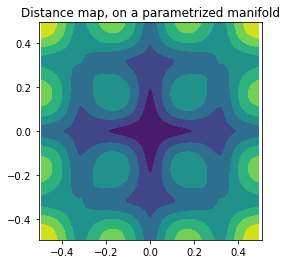

In [13]:
plt.figure(figsize=[4,4]); plt.title('Distance map, on a parametrized manifold'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOut['values']);

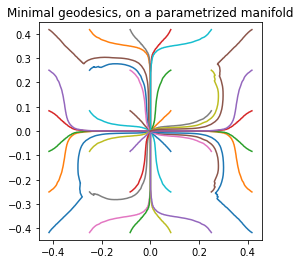

In [14]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal geodesics, on a parametrized manifold'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(*geo) 
savefig(fig,'ParametrizedGeodesics.png')

In [15]:
if useMayavi:
    for geo in hfmOut['geodesics']:
        mlab.plot3d(geo[0],geo[1],np.array([Elevation(x,y) for (x,y) in geo]),tube_radius=0.01)
    mlab.surf(X,Y,Z)
    mlab.view(azimuth=-60,distance=4,elevation=30)
    mlab.show()

This should be displayed in the Mayavi window.
![Embedded surface and geodesics](https://dl.dropbox.com/s/b7jpocelfo1y6s0/EmbeddedGeodesics.png)

Similar to the isotropic case, the minimal Riemannian geodesic $\gamma$ from $\partial \Omega$ to a point $x \in \Omega$ obeys an Ordinary Differential Equation (ODE). This equation is solved backwards in time and involves a *terminal* boundary condition, at the final time $T = u(x)$, and reads:
\begin{align*}
    \forall t \leq T, \gamma'(t) &= V(\gamma(t)), &
    \gamma(T) &=x
\end{align*}
The vector field $V : \Omega \to {\mathbb R}^2$ is referred to as the geodesic flow direction, and is related with the solution $u$ of the eikonal PDE by the relation
\begin{equation*}
    V(x) := D(x) \nabla u(x).
\end{equation*}
The geodesic flow returned by the HFM sofware is computed in an upwind manner, taking advantage of the properties of the numerical scheme. This approach is expected to be more stable than the naive approach, namely approximating of $\nabla u(x)$ using finite differences and post-multplying by $D(x)$.

Note that what we call the 'geodesic flow' is referred to as the 'Riemannian gradient of $u$' by mathematical geometers.

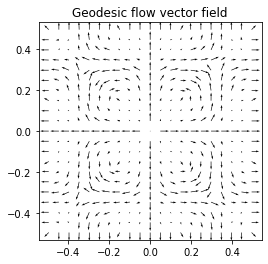

In [16]:
plt.figure(figsize=[4,4]); plt.title('Geodesic flow vector field'); plt.axis('equal'); 
quiver(X,Y,*hfmOut['flow'],subsampling=(5,5));

The geodesic flow has unit norm w.r.t. the Riemannian metric. Let us check this property formally: recalling that $D(x) = M(x)^{-1}$ is the inverse metric tensor
\begin{equation*}
\| V(x)\|_{M(x)}^2 = V(x)^T \cdot M(x) \cdot V(x) = \nabla u(x)^T D(x) M(x) D(x) \nabla u(x) = \nabla u(x)^T D(x) \nabla u(x) = \|\nabla u(x)\|^2_{D(x)}.
\end{equation*}
Numerically, this identity does approximately hold, except at the seed point.

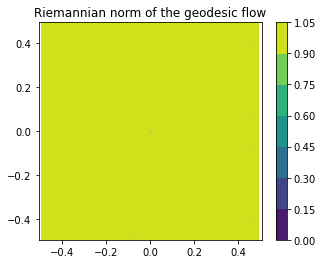

In [17]:
plt.figure(figsize=[5,4]); plt.title('Riemannian norm of the geodesic flow'); plt.axis('equal')
flowNorms = hfmIn['metric'].norm(hfmOut['flow'])
plt.contourf(X,Y,flowNorms); plt.colorbar();

Contrary to the isotropic case, and to what the previous figure suggests, the flow norm is not exactly one. This is due to the discretization error, and illustrated in the following figure.

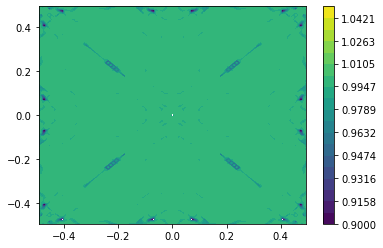

In [18]:
plt.contourf(X,Y,flowNorms, levels = np.linspace(0.90,1.05,20))
plt.colorbar(); # TODO : tighter level lines around 1

In [19]:
hfmIn.pop('metric',None);
hfmIn.pop('dualMetric',None);

### 1.2 Defining a metric by its eigenvectors and eigenvalues

In this second experiment, inspired by seismic imaging, we consider a metric $M$ with two eigenvalues $\alpha^{-2}$ and $\beta^{-2}$. The first one is associated with some eigenvector $v$, assumed to be of unit norm, and the second one with the orthogonal direction $v^\perp$.
\begin{equation*}
    M(x,y) = \alpha(x,y)^{-2} v(x,y)\cdot v(x,y)^\perp + \beta(x,y)^{-2} v^\perp(x,y)\cdot v^\perp(x,y)^T.
\end{equation*}
The coefficient field $\alpha: \Omega \to ]0,\infty[$ should be regarder as the maximum speed allowed locally in the direction of the vector field $v : \Omega \to \mathbb R^2$. The coefficient $\beta$ is likewise the maximum allowed speed in the orthogonal direction. In contrast, the isotropic metrics considered in the previous notebooks only have one speed function (the speed function is the inverse $s=1/c$ of the cost function).

The inverse tensor field $D=M^{-1}$ admits an expression similar to the metric
\begin{equation*}
    D(x,y) = \alpha(x,y)^2 v(x,y)\cdot v(x,y)^T + \beta(x,y)^{2} v^\perp(x,y)\cdot v^\perp(x,y)^T.
\end{equation*}

<!---
We first define a function which constructs the metric $M$, or its dual $D$, given the scalar fields $\alpha,\beta$ and the components of the vector field $v = (v_x,v_y)$. This function can handle non-normalized vector fields, and infers alone the orthogonal direction. The mathematical justification of its correctness is left as an exercise to the reader.

# Create a metric with eigenvalue alpha^(-2) in the direction [Vx,Vy], and beta^(-2) in the orthogonal direction
#def synthetiseMetric2(alpha,beta,Vx,Vy,dual=False):
#    VNorm2 = Vx**2+Vy**2
#    e = 2 if dual else -2
#    a = alpha**e/VNorm2
#    b = beta**e/VNorm2
#    return np.stack((a*Vx*Vx+b*Vy*Vy, (a-b)*Vx*Vy, a*Vy*Vy+b*Vx*Vx),2)
--->

We choose the parameters $\alpha=0.8$, $\beta=0.2$, and $V=(1,(\pi/2)\cos(4 \pi x))$, so as to reproduce a classical test case. Note that $\alpha$ and $\beta$ could equally well be position dependent.

In [20]:
alpha,beta = 0.8,0.2
V = xp.ones(X.shape),(np.pi/2)*np.cos(4*np.pi*X)
hfmIn['metric'] = Riemann.needle(V,alpha,beta).dual()
hfmIn['exportGeodesicFlow']=0 # The geodesic flow is not used in this example

The metric anisotropy is the ratio $\alpha/\beta$ of the square root of its eigenvalues.

In [21]:
print(f"Metric max anisotropy = {np.max(hfmIn['metric'].anisotropy())}. (alpha/beta = {alpha/beta})")

Metric max anisotropy = 4.000000000000005. (alpha/beta = 4.0)


In [22]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.006331 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


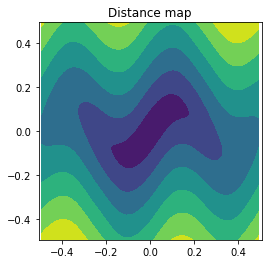

In [23]:
plt.figure(figsize=[4,4]); plt.title('Distance map'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOut['values']);

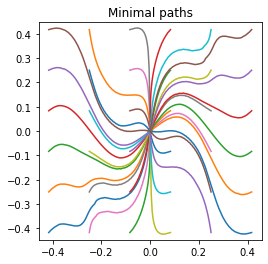

In [24]:
plt.figure(figsize=[4,4]); plt.title('Minimal paths'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(*geo);

In [25]:
hfmIn.pop('metric',None);
hfmIn.pop('dualMetric',None);

### 1.3 A discontinuous and extremely anisotropic Riemannian metric

We illustrate the robustness of the HFM library by considering a hard test case, related with medical image processing, and in particular with tubular structure segmentation. The condition number $100^2$ of the metric tensors exceeds what we would typically recommend, namely $10^2$ at most. The the discontinuities of the metric fall outside the scope of the mathematical convergence analysis of our numerical method. Nevertheles, the HFM software yields results that are usable and behave as expected qualitatively.

We define a Riemannian metric $M : \Omega \to S^++(\mathbb R^2)$ which strongly favors paths remaining close and tangent to a given curve $\Gamma$.
More precisely, yhe metric tensor $M(p)$, at a point $p\in ]0.5,0.5[^2$, is defined as the identity matrix,
except on a neighborhood of width $0.01$ of the spiraling curve parametrized by
\begin{equation*}
\Gamma(t) = t (\cos(\omega t), \sin(\omega t)),
\end{equation*}
where $t\in [0,0.43]$, and $\omega=12 \pi$. On this, extremely thin, neighborhood of the curve $\Gamma$, the metric tensor has an extremely small eigenvalue $0.01^2$ associated with the eigenvector $\Gamma'(t)$. The second eigenvalue is $1$. 

In [26]:
# For better results, we slightly increase the resolution of the domain.
hfmIn.SetRect(sides=[[-0.5,0.5],[-0.5,0.5]],dimx=201)
X,Y = hfmIn.Grid()

A short mathematical analysis, not presented here, allows to deduce the following expressions of the curve neighborhood and tangent.

In [27]:
omega = 12*np.pi
curveNeighborhoodWidth = 0.01
inverseAnisotropy = 0.01

R=np.sqrt(X**2+Y**2)
Theta=np.arctan2(Y,X)

CurveNeighborhood = np.logical_and(np.remainder(R*omega - Theta,2.*np.pi) <= omega*curveNeighborhoodWidth, R<=0.43)
CurveTangentx = -R*omega*np.sin(Theta)+np.cos(Theta)
CurveTangenty =  R*omega*np.cos(Theta)+np.sin(Theta)

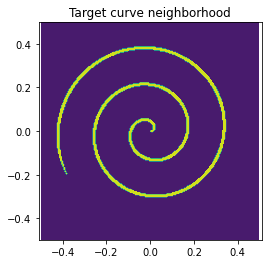

In [28]:
plt.figure(figsize=[4,4]); plt.title('Target curve neighborhood'); plt.axis('equal'); 
plt.contourf(X,Y,CurveNeighborhood);

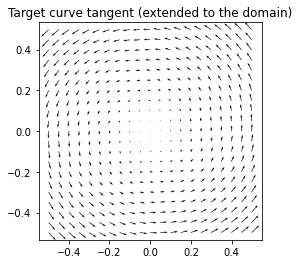

In [29]:
plt.figure(figsize=[4,4]); plt.title('Target curve tangent (extended to the domain)'); plt.axis('equal'); 
quiver(X,Y,CurveTangentx,CurveTangenty,subsampling=(10,10));

In [30]:
hfmIn['metric'] = Riemann.needle([CurveTangentx,CurveTangenty],xp.where(CurveNeighborhood,inverseAnisotropy,1.),1.)

This metric has an extremely strong anisotropy, at the limit of what the HFM library can handle.

In [31]:
print(f"Max metric anisotropy : {np.max(hfmIn['metric'].anisotropy())}. (1/inverseAnisotropy = {1/inverseAnisotropy})")

Max metric anisotropy : 100.00000000021367. (1/inverseAnisotropy = 100.0)


In [32]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.02167 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


We observe numerically, as was desired from the thoretical standpoint, that the shortest path from an arbitrary point to the domain center is the concatenation of the following two parts
* First: reach for the curve $\Gamma$, in straight line.
* Second: follow the curve $\Gamma$, up to its origin. 

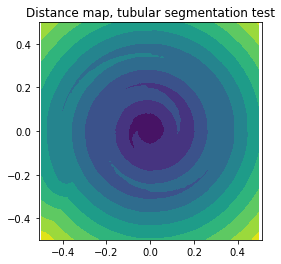

In [33]:
plt.figure(figsize=[4,4]); plt.title('Distance map, tubular segmentation test'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOut['values'],10);

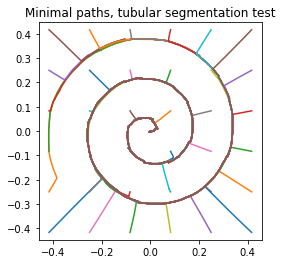

In [34]:
plt.figure(figsize=[4,4]); plt.title('Minimal paths, tubular segmentation test'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(*geo)

In [35]:
hfmIn.pop('metric',None);
hfmIn.pop('dualMetric',None);

### 1.4 Axis dependent grid scale

The grid scale, along each axis, can be specified independently. We reproduce one of the above examples with this feature on. (This is also possible with the isotropic model.)

In [36]:
#Square domain, axis dependent grid scale
hfmIn = Eikonal.dictIn({
    'model' : 'Riemann2',
    'seeds' : [[0.,0.]],
    'exportValues':1,
})
hfmIn.SetRect(sides=[[-0.5,0.5],[-0.5,0.5]],gridScales=[0.01,0.02]) 
X,Y = hfmIn.Grid()
hfmIn['metric'] = Riemann.needle([xp.ones(X.shape),(np.pi/2)*np.cos(4*np.pi*X)],0.8,0.2).dual()

In [37]:
print("Number of points along the horizontal and vertical axes:",hfmIn['dims'])

Number of points along the horizontal and vertical axes: [100.  50.]


In [38]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.002289 s.


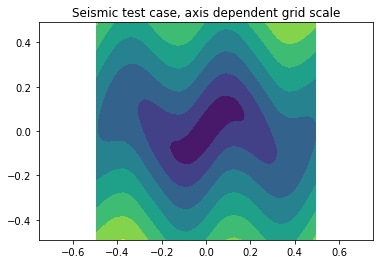

In [39]:
plt.axis('equal'); plt.title("Seismic test case, axis dependent grid scale")
plt.contourf(X,Y,hfmOut['values']); 

## 2. Three dimensional examples

We conclude this notebook with by solving some three dimensional minimal path problems, with respect to anisotropic Riemannian metrics. Two test cases are considered, generalizing the two dimensional ones. More precisely, we illustrate:
* the accuracy of our discretization with a test involving a smooth Riemannian metric.
* the robustness of our method with a second test case involving a strongly an anisotropic and discontinuous metric.

At the time of writing, generic Riemannian metrics in dimension four and above are not handled by the HFM software.

In [40]:
hfmIn = Eikonal.dictIn({
    'model':'Riemann3', # Three-dimensional Riemannian eikonal equation
    'exportValues':1,
    'seed':[0.,0.,0.],
})

# Define the domain and get a coordinate system
hfmIn.SetRect(sides=[[-0.5,0.5],[-0.5,0.5],[-0.5,0.5]],dimx=101)
X,Y,Z = hfmIn.Grid()

hfmIn.SetUniformTips((4,4,4))

### 2.1 A smooth Riemannian metric

We generalize to three dimensions the test case 1.b, inspired by seismic imaging. Our Riemannian metric tensors again has two eigenvalues $\alpha^{-2}$ and $\beta^{-2}$. The former is associated with a field $v$ of unit vectors, and later with the orthogonal plane. For any $p =(x,y,z)\in \mathbb R^3$, we let $M(p) \in S^++(\mathbb R^3)$ be defined by 
\begin{equation*}
M(p) = \alpha(p)^{-2} v(p)\cdot v(p)^T + \beta(p)^{-2} ( \mathrm{Id}_3 - v(p)\cdot v(p)^T).
\end{equation*}
We denoted by $\mathrm{Id}_3$ the $3\times 3$ identity matrix. 
As in the two dimensional case, the dual metric $D = M^{-1}$ is obtained by reciprocating the coefficients $\alpha,\beta : \Omega \to ]0,\infty[$
\begin{equation*}
D(p) = \alpha(p)^{2} v(p)\cdot v(p)^T + \beta(p)^{2} ( \mathrm{Id}_3 - v(p)\cdot v(p)^T).
\end{equation*}

<!---
This metric, and its dual, are synthetized by the following function, which does not require the vector field $v : \Omega \to {\mathbb R}^3$ to be normalized.

# Create a metric with eigenvalue alpha^(-2) in the direction [Vx,Vy,Vz], and beta^(-2) in the orthogonal plane.
def synthetizeMetric3(alpha,beta,Vx,Vy,Vz,dual=False):
    VNorm2 = Vx**2+Vy**2+Vz**2
    e = 2 if dual else -2
    c = (alpha**e-beta**e)/VNorm2
    return np.stack((c*Vx**2+beta**e, 
                     c*Vx*Vy, c*Vy**2+beta**e,
                     c*Vx*Vz, c*Vy*Vz, c*Vz**2+beta**e
                    ),3)
--->

Reproducing the example in [[Mir17]](#cite_Mirebeau_2017_Voronoi), we choose the eigenvalues $0.2^{-2}$ and $0.8^{-2}$, and let the field of eigenvectors be $(\cos (3 \pi (x+y)), \sin (3 \pi (2 x-y)), 0.5)$.

In [41]:
hfmIn['metric'] = Riemann.needle([np.cos(3*np.pi*(X+Y)), np.sin(3*np.pi*(2*X-Y)), 0.5*xp.ones(X.shape)],0.2,0.8).dual()

In [42]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 2.53519 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


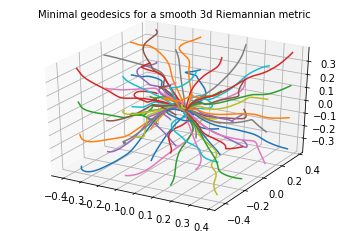

In [43]:
ax = plt.figure().gca(projection='3d')
ax.text2D(0.5,0.95,"Minimal geodesics for a smooth 3d Riemannian metric",transform=ax.transAxes,horizontalalignment='center')
for geodesic in hfmOut['geodesics']:  plt.plot(*geodesic)

In [44]:
if useMayavi: # Show the solution level set
    mlab.contour3d(hfmOutput['values'], contours=[0.3])
    mlab.view(azimuth=120, elevation=30)
    mlab.show() # Displays in an external window. 

This is what the previous command should display (with an appropriate viewpoint).

![Solution level set](https://dl.dropbox.com/s/jjsaya4foffiu1c/2_Riemannian_Contour3D.png?dl=0)

### 2.2 A discontinuous and strongly anisotropic Riemannian metric

Our second example involves discontinuous and strongly anisotropic three dimensional Riemannian metric, which favors paths remaining close and tangent to the curve $\Gamma : [0,3] \to {\mathbb R}^3$ of parametrization
\begin{equation*}
\Gamma(t) := (\cos \omega t, \sin \omega t, t),
\end{equation*}
where $\omega := \frac 5 2 \pi$.
More precisely, the metric tensors are equal to the identity matrix, except on a tube of radius 0.02 around the curve $\Gamma$, where they have eigenvalues $(0.02^2,1,1)$, the former being associated with the tangent vector $\Gamma'(t)$.

This test case is inspired by applications to tubular structure segmentation.
The condition number $50^2$ of these metric tensors, significantly exceeds what we would advise, namely $10^2$ at most. In addition, it falls outside the scope of our mathematical convergence analysis, due to its discontinuities. Nevertheless, the obtained numerical results are qualitatively satisfying, illustrating the robustness of our numerical method.

In [45]:
omega = (5/2)*np.pi
delta = 0.02
r = 0.02
n=200 # We double the resolution for this test case.

hfmIn.SetRect(sides=[[-1.1,1.1],[-1.1,1.1],[0,3]],dimx=n)

X,Y,Z = hfmIn.Grid()
Theta = np.arctan2(Y,X)

def symmetricRemainder(x,n): return x - np.round(x/n)*n
curveNeighborhood = symmetricRemainder(Z-Theta/omega,2.*np.pi/omega)**2+ \
    (X-np.cos(Theta))**2+(Y-np.sin(Theta))**2 <= (r/2)**2
curveTangentX,curveTangentY,curveTangentZ = -omega*np.sin(omega*Z), omega*np.cos(omega*Z), xp.ones(Z.shape)

The neighborhood of the curve $\Gamma$, where the metric tensors are distinct from the identity matrix, is only a few pixels thick as shown in the following visualization.

In [46]:
if useMayavi:
    mlab.contour3d(curveNeighborhood.astype(float), contours=[0.7])
    mlab.show() # Displays in an external window. 

This is what the mayavi window should display.
![Curve neighborhood](https://dl.dropbox.com/s/4yvgdgq2k1f2ykj/2_Riemannian_TubularSupport.png?dl=0)
We next gather the problem input description, and call the HFM sofware.

In [47]:
hfmIn.update({
    'metric':Riemann.needle([curveTangentX,curveTangentY,curveTangentZ],xp.where(curveNeighborhood,delta,1.),1.),
    'seed':[0.,0.,0.01],
    'tip':[0.,0.,2.99],
})

In [48]:
# Computations may take up to a minute for this rather large scale instance
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 17.2469 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


A contour plot illustrates, as expected, the that the front propagation goes extremely fast along the spiraling curve $\Gamma$.

In [49]:
if useMayavi:
    mlab.contour3d(hfmOutput['values'], contours=[0.7,1.6])
    mlab.show() # Displays in an external window. 

This is what the mayavi window should display.
![Solution level set](https://dl.dropbox.com/s/ofvmbx6bol33c7x/2_Riemannian_TubularContour.png?dl=0)

The minimal geodesic from $(0,0,0)$ to $(0,0,3)$, illustrated below, is qualitatively the concatenation of three parts:
* a straight line from the seed to the neighborhood of the curve $\Gamma$
* a part close and tangent to the curve $\gamma$.
* a straight line from the curve $\gamma$ to the geodesic tip.

<!---
if eikonal_mode=='gpu':hfmIn['geodesic_Stationnary_delay']=400
--->

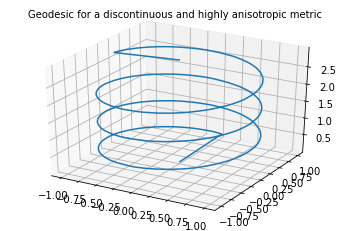

In [50]:
ax = plt.figure().gca(projection='3d')
ax.text2D(0.5,0.95,"Geodesic for a discontinuous and highly anisotropic metric",transform=ax.transAxes,horizontalalignment='center')
plt.plot(*hfmOut['geodesic']);

In [51]:
if hfmIn.mode=='gpu': 
    raise ad.DeliberateNotebookError("Avanced stopping criteria and automatic differentiation not implemented on GPU")

## 3. Sensitivity analysis

Sensitivity analysis, also referred to as forward and backward differentation, is described in the [previous notebook](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/1_Sensitivity.ipynb), in the context of isotropic metrics. This feature is also available for anisotropic Riemannian metrics.
More precisely, we consider perturbations of the eikonal equation of the form 
\begin{align*}
    \forall x \in \Omega, \| \nabla_\varepsilon u(x)\|_{D(x)} &= 1+\varepsilon\xi(x), &
    \forall x \in \partial \Omega, u_\varepsilon(x) &= \sigma(x)+\varepsilon \zeta(x). 
\end{align*}
The calling procedure is similar to the isotropic case.

One may also be interested in more general sensitivity analysis, w.r.t. generic changes in the (inverse) metric tensors, as follows
\begin{equation*}
D_\varepsilon(x) = D(x)+\varepsilon \Xi(x).
\end{equation*}
This currently exists as well in the HFM software, but only as an experimental and undocumented feature so far. Please contact the author in case of interest.

Our first step is to define the optimal control problem to be studied.

In [52]:
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',
    'exportValues':1,
    'order':1,
    'seed':[0,0],
})

# Define the domain, here ]-0.5,0.5[^2
hfmIn.SetRect(sides=[[-0.5,0.5],[-0.5,0.5]],dimx=101)
X,Y = hfmIn.Grid()

# Problem parameters, here similar to section 1.b
hfmIn['metric'] = Riemann.needle([xp.ones(X.shape),(np.pi/2)*np.cos(4*np.pi*X)],0.8,0.2).dual()
hfmIn.SetUniformTips((6,6))

### 3.1 Backward differentiation

Let us first consider backward differentiation, aka reverse mode sensitivity analysis. Denote by $u_\varepsilon : \overline \Omega \to \mathbb R$ the solution to the eikonal equation 
\begin{align*}
\forall x \in \Omega, \|\nabla u_\varepsilon(x)\|_{D(x)} &= 1+\varepsilon \xi(x) & 
\forall x \in \partial \Omega, u_\varepsilon(x) &= \sigma(x)+\varepsilon \zeta(x).
\end{align*}
<a id='Taylor_Solution'></a>
Let also $x_*\in \Omega$. Then, formally, similarly to the isotropic case, there exists fields $\rho : \Omega \to \mathbb R$ and $\pi : \partial \Omega \to \mathbb R$ such that for any perturbations $\xi, \zeta$
\begin{equation*}
u_\varepsilon(x_*) = u(x_*)+ \varepsilon \left(\int_\Omega \rho\xi + \int_{\partial_\Omega} \pi \zeta\right) + o(\varepsilon).
\end{equation*}

In [53]:
hfmIn['inspectSensitivity']=hfmIn['tips'][0:10] # Inspect the sensitivity of the solution at some of the tips

In [54]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.004909 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


The cost sensitivity field $\xi$ can be regarded as a diffuse representation of the geodesic from $x_*$ to the closest seed. This property, illustrated in the following visualization, is at the foundation of one of our backtracking methods. 

We here display the geodesic, and the sensitivity, associated with the sixth tip.

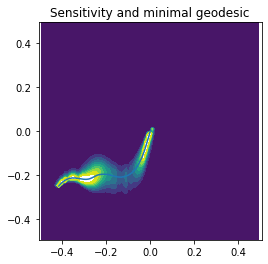

In [55]:
plt.figure(figsize=[4,4]); plt.title('Sensitivity and minimal geodesic'); plt.axis('equal'); 
plt.plot(*hfmOut['geodesics'][1]);
plt.contourf(X,Y,hfmOut['costSensitivity_1'],levels=np.linspace(0,0.005,10));

The sensitivity $\pi : \partial \Omega \to \mathbb R$ to the boundary conditions is rather trivial: it is a Dirac mass, of weight $1$, located at the unique seed $(0,0)$.

In [56]:
hfmOut['seedSensitivity_1']

array([[0., 0., 1.]])

We discuss a consistency test based on Euler's identity for homogeneous functions. Assume that the cost perturbation is $\xi = 1$, and observe that we the boundary conditions were chosen null. Then, by a basic rescaling argument, one obtains 
$
    u_\varepsilon = (1+\varepsilon) u 
$ on all of $\Omega$, for any $\varepsilon \in ]-1,\infty[$.

Comparing this with the [Taylor expansion](#Taylor_Solution) of the solution, we conclude that 
\begin{equation*}
u(x_*) = \int_\Omega \rho.
\end{equation*}
This equality is checked numerically in the next line.

In [57]:
index_1,_ = hfmIn.IndexFromPoint(hfmIn['inspectSensitivity'][1])
assert np.abs(hfmOut['costSensitivity_1'].sum() - hfmOut['values'][tuple(index_1)]) < 1e-15

### 3.2 Forward differentiation

In forward differentiation mode, one explicitly provides the variation $\xi$ in the cost, and $\zeta$ in the boundary conditions (here null by default). The first order term $\mu : \Omega \to \mathbb R$ in the Taylor expansion of the solution is recovered, such that 
\begin{equation*}
    u_\varepsilon(x) = u(x)+\varepsilon \mu(x) + o(\varepsilon).
\end{equation*}
Two cases are considered: a uniform variation $\xi=1$ of the cost for a consistency check, and a generic variation $\xi=x+y^2$. No variation is imposed on the boundary conditions.

In [58]:
hfmIn['costVariation'] = np.stack([1.+0.*X, X+Y**2],axis=2) # Fist order perturbation of the cost (problem r.h.s)

In [59]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.004797 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


By Euler's identity for homogeneous functions, one gets $\mu = u$ in the case $\xi=1$ of the uniform variation.

In [60]:
values = hfmOut['values'] # First order dense automatic-differentiation variable
assert np.max(np.abs(values.gradient(0) - values.value)) < 1e-14

We next compare the forward differentiation with backward sensitivity analysis, for consistency again.
More precisely, with the above notations, we check that 
\begin{equation*}
\nu(x_*) = \int_\Omega \rho \xi 
\end{equation*}

In [61]:
assert np.abs(hfmOut['values'][tuple(index_1)].gradient(1) - 
      (hfmOut['costSensitivity_1']*hfmIn['costVariation'][:,:,1]).sum()) < 1e-15

In [62]:
# Restore input
hfmIn.pop('costVariation',None);
hfmIn.pop('inspectSensitivity',None);

## 4. Voronoi regions

We illustrate the Voronoi diagram associated with a family of seeds. A similar experiment, with isotropic metrics instead of anisotropic Riemannian metrics, is presented in the [first notebook](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/0_Isotropic.ipynb).

In [63]:
hfmIn['seeds']=[[0.,0.2],[-0.2,-0.1],[0.2,-0.1]]
hfmIn['seedFlags']=[0,1,2]

In [64]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Field voronoiStoppingCriterion defaults to None
Fast marching solver completed in 0.006992 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportVoronoiFlags defaults to 1


The computation of Voronoi diagrams is more challenging with anisotropic metrics, such as Riemannian metrics, than with isotropic ones. Indeed, the numerical scheme relies on wide adaptive stencils, which risks blurring the lines between the regions. 

Qualitatively convincing results are obtained though, largerly because the stencils of the FM-VR1 numerical scheme used in the HFM software remain rather compact.

In [65]:
int(hfmOut['MaxStencilWidth']) # Returns the size of the widest stencil used in the discretization.

3

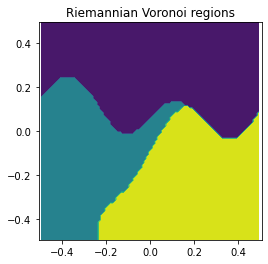

In [66]:
plt.figure(figsize=[4,4]); plt.title('Riemannian Voronoi regions'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOut['voronoiFlags']);

In the next experiment, we stop the front propagation as soon as two of the regions meet, and display the minimal paths from the meeting point. They can be concatenated into a minimal geodesic joining the two closest seeds.

In [67]:
hfmIn['voronoiStoppingCriterion']='RegionsMeeting'

In [68]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.001822 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportVoronoiFlags defaults to 1


Field voronoiDiagram_exportGeodesicFromMeetingPoint defaults to 1


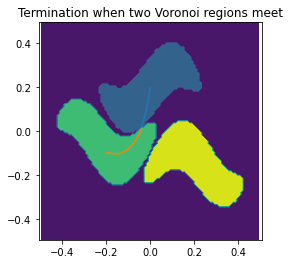

In [69]:
plt.figure(figsize=[4,4]); plt.title('Termination when two Voronoi regions meet'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOut['voronoiFlags']) # Display the Voronoi regions.
for geo in hfmOut['geodesics_voronoiDiagram']:  plt.plot(*geo) 

The same flag can be attributed to several seeds. As a result, the corresponding Voronoi regions are regarded as a single, unique region.

In [70]:
hfmIn['seedFlags']=[0,0,1]

In [71]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.001901 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportVoronoiFlags defaults to 1
Field voronoiDiagram_exportGeodesicFromMeetingPoint defaults to 1


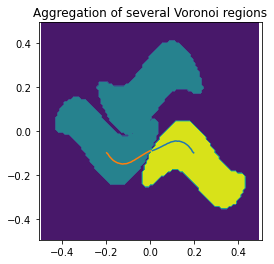

In [72]:
plt.figure(figsize=[4,4]); plt.title('Aggregation of several Voronoi regions'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOut['voronoiFlags']) # Display the Voronoi regions.
for geo in hfmOut['geodesics_voronoiDiagram']:  plt.plot(*geo) 

In [73]:
hfmIn.pop('voronoiStoppingCriterion',None);

## 5. Contruction of the Riemannian tensors

In applications, the construction of the Riemannian metric tensors is often the key difficulty, requiring expert knowledge of the problem at hand. A few classical constructions are illustrated in this series of notebooks.

### 5.1 Dimension lifting

The HFM software implements Riemannian models in dimension $d+1$, where $d \in \{2,3\}$, and the tensor structure is block diagonal. They take the form
\begin{equation*}
\mathcal D(p)=
\begin{pmatrix}
D(p) & \\
& \lambda(p)
\end{pmatrix}
\end{equation*}
where $D(p)$ is a $d\times d$ symmetric positive definite matrix, and $\lambda(p)>0$.
These tensor structures are common in image processing, where usually $d$ is the input image dimension, and the last coordinate is an abstract parameter. Usually it accounts for a feature of the objects represented in the image, expected to vary regularly along them, such as the radius, orientation, or gray level of some tubular structures.

Such models are discussed in the [notebook on tubular structures extraction](Tubular.ipynb). A related construction allows to penalize curvature, see the notebooks on [curvature](Curvature.ipynb) and [distorted curvature](DeviationHorizontality.ipynb).

### 5.2 Mapping the eigenvalues of a given tensor field.

Another approach is to extract direction information from an image in the form of a symmetric matrix field $A$. To this end, one may consider the hessian, the structure tensor, the oriented flux of L. Cohen, or some other filter.
At each discretization point $x$, the eigen decomposition of $A$ reads:
$$
    A(x) = \sum_{1 \leq i \leq d} \lambda_i(x) e_i(x) e_i(x)^T.
$$

The eigenvectors $(e_i)$ of the previous tensor typically indicate well the directions of interest in the image, e.g. the directions of the tubular structures or the objects contours. However the eigenvalues $\lambda_i$ are usually not adequate for minimal path computation: they may have a negative sign, an excessive magnitude, etc. 

A typical construction is to construct a Riemannian metric tensor which has the same eigenvectors $e_i$ as the filtered tensor, but eigenvalues $\mu_i$ mapped in an arbitrary way. 
$$
    M(x) = \sum_{1 \leq i \leq d} \mu_i(x) e_i(x) e_i(x)^T
$$
where
$$
    (\mu_1(x),\mu_2(x),\mu_3(x)) = f(\lambda_1(x),\lambda_2(x),\lambda_3(x))
$$
for some given function $f$. For convenience, one expects that $\lambda_1(x) \leq \lambda_2(x) \leq \lambda_3(x)$: the eigenvalues are sorted by increasing value.

We provide a helper function for applying this strategy, documented below. We do not illustrate it on real data, but only test it on a random example for correctness.

**Anisotropy of the metric.**
The largest value of $\mu_{\max} := \sqrt{\mu_i(x)/\mu_j(x)}$, for $i,j\in \{1,2,3\}$ and $x\in \Omega$, is the anisotropy of the produced metric. For best results, please ensure that $\mu_{\max} \lesssim 10$, or at the very least $\mu_{\max} \lesssim 100$.


In [74]:
# Construct a symmetric tensor describing an image's features (hessian, structure tensor, etc)
# Here, we content ourselves with random data
image_dim = 3
image_shape = (5,6,7)

np.random.seed(0) # Reproducibility
A = np.random.normal( size=(image_dim,image_dim)+image_shape)
A = A+lp.transpose(A) # Make symmetric

In [75]:
# Construct a function for mapping the eigenvalues. 
# Important : in practical applications, mu0,mu1,mu2 must all be positive
def f(eigenvalues):
    lambda0,lambda1,lambda2 = eigenvalues
    mu0,mu1,mu2 = lambda0,lambda1+1,lambda2+2
    return mu0,mu1,mu2

# The Riemannian metric
M = Riemann.from_mapped_eigenvalues(A,f)

We check below some of the properties of proposed construction.

In [76]:
def f_inv(x):
    x0,x1,x2 = x
    # Test that the eigenvalues are sorted as expected.
    assert np.all(x0<=x1) and np.all(x1<=x2)
    return x0,x1-1,x2-2

# Test that composing f and f_inv yields identity
assert norm_infinity(Riemann.from_mapped_eigenvalues(M.m,f_inv).m - A) < 1e-13

# Test that the mapping lambda->1/lambda yields the inverse matrix
A_inv = Riemann.from_mapped_eigenvalues(A,lambda t:1/t).m
Id = np.eye(image_dim).reshape( (image_dim,image_dim)+image_dim*(1,) )
assert norm_infinity(lp.dot_AA(A_inv,A) - Id)<1e-12